# Projeto 3 - Ciência dos Dados

#### Stephanie Wertheimer, Thomas Pilnik e Victor Sznifer

Nesse projeto, temos duas bases de dados: uma com dados laboratoriais a respeito quantidade de E. Coli presente na água das praias de Chicago, Illinois, e outra que mensura diferentes características físicas da água, ambas em diferentes datas e horários. Nosso objetivo é buscar uma relação entre a proliferação de bactérias e os parâmetros físicos utlizados para analisar a água. Faremos isso usando um modelo de regressão linear e analisando a correlação entre a concentração de bactérias e as diferentes variáveis físicas. 

In [3]:
#Importando diretórios

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math

In [4]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\steph\OneDrive\Documents\Engenharia Insper\2° semestre\Ciência dos Dados\Projeto_3


Abaixo fizemos as edições necessárias em nomes das células para conseguir fazer as alterações necessárias posteriormente para relacionar informações:

In [5]:
#Abrindo bases de dados
lab = pd.read_csv('Beach_Lab_Data.csv', sep=',')
water = pd.read_csv('Beach_Water_Quality_-_Automated_Sensors.csv', sep=',')

#Editando as colunas dos Data Frames

lab.columns = ["DNATestID", "Timestamp", "Beach", "DNA1","DNA2", "DNAMean", "CultureTestID","Sample1TimeStamp","Sample1Reading","Sample2Reading","ReadingMean","CultureNote","SampleInterval","Sample2TimeStamp","Latitude","Longitude","Location"]
water.columns = ["Beach", "Timestamp", "WtrTemperature", "Turbidity","TransducerDepth", "WaveHeight", "WavePeriod", "BatteryLife","TimestampLabel","ID"]


#Selecionando as colunas do Date Frame 
lab = pd.DataFrame(lab.loc[:, ["DNATestID", "Beach", "DNAMean","ReadingMean","Sample1TimeStamp"]])
water=pd.DataFrame(water.loc[:, ["Beach", "WtrTemperature", "Turbidity","TransducerDepth", "WaveHeight", "WavePeriod", "TimestampLabel"]])

#Editando e padronizando o nome das praias

lab=lab.drop(lab[lab.Beach == 'Margaret T Burroughs'].index)
lab=lab.drop(lab[lab.Beach == 'Margaret T Burroughs'].index)
lab=lab.drop(lab[lab.Beach == 'South Shore'].index)
lab=lab.drop(lab[lab.Beach == '12th Street'].index)
lab=lab.drop(lab[lab.Beach == 'North Avenue'].index)
lab=lab.drop(lab[lab.Beach == 'Humboldt'].index)

lab['Sample1TimeStamp']=pd.to_datetime(lab.Sample1TimeStamp).dt.date

water=water.drop(water[water.Beach == 'Osterman Beach'].index)

water['Nível']='Médio'
water.loc[(water.Beach == "Montrose Beach"), "Nível"] = "Montrose"
water.loc[(water.Beach == "Calumet Beach"), "Nível"] = "Calumet"
water.loc[(water.Beach == "Ohio Street Beach"), "Nível"] = "Ohio Street"
water.loc[(water.Beach == "Rainbow Beach"), "Nível"] = "Rainbow"
water.loc[(water.Beach == "63rd Street Beach"), "Nível"] = "63rd Street"

del water['Beach']

#Padronizando data e hora do Data Frame de dados da água 

water['TimestampLabel']=pd.to_datetime(water.TimestampLabel).dt.date

Nossa base de dados teve as colunas filtradas de acordo com as variáveis que julgamos necessárias para fazer nossa análise.
No caso da base de dados de dados laboratoriais, decidimos que só era importante para nós analisar a média, e o horário. A medição que usamos para fazer as análises nesse sentido é a Reading Mean, dada em CPU.
CFU- Colony-Forming Unit

Em microbiologia, a CFU é usada para estimar o número de células de bactérias ou fungos viáveis em uma amostra. Ser viável significa ser capaz de se multiplicar por meio de fissão binária (mitose).

Já para as características físicas da água, decidimos analisar a Turbidez, Temperatura, Período da Onda, Altura da Onda, e Profundidade do Transductor. 

In [6]:
lab.head()

,DNATestID,Beach,DNAMean,ReadingMean,Sample1TimeStamp
0,NaN,NaN,NaN,239.3,2013-08-15
2,NaN,Hartigan,NaN,69.0,2010-06-02
5,NaN,Marion Mahony Griffin,NaN,7.1,2015-08-13
7,NaN,Marion Mahony Griffin,NaN,57.8,2007-08-17
8,NaN,Hartigan,NaN,10.8,2015-09-04


In [7]:
water.head()

,WtrTemperature,Turbidity,TransducerDepth,WaveHeight,WavePeriod,TimestampLabel,Nível
0,20.3,1.18,0.891,0.080,3.0,2013-08-30,Montrose
1,14.4,1.23,NaN,0.111,4.0,2016-05-26,Ohio Street
2,23.2,3.63,1.201,0.174,6.0,2013-09-03,Calumet
3,16.2,1.26,1.514,0.147,4.0,2014-05-28,Calumet
4,14.4,3.36,1.388,0.298,4.0,2014-05-28,Montrose


Para conseguir relacionar as informações das bases de dados, tivemos que usar o join. Precisávamos relacionar informações por meio de localização geográfica, ou seja, pelo nome da praia, e também pelo horário. Como precisávamos cruzar duas informações, usamos o módulo merge do pandas. 

In [8]:
#join das duas bases de dados 

joined = lab.set_index('Beach').join(water.set_index('Nível'), how='inner', lsuffix='lab', rsuffix='_water')

new_df = pd.merge(lab, water,  how='inner', left_on=['Beach','Sample1TimeStamp'], right_on = ['Nível','TimestampLabel'])

new_df.head()


,DNATestID,Beach,DNAMean,ReadingMean,Sample1TimeStamp,WtrTemperature,Turbidity,TransducerDepth,WaveHeight,WavePeriod,TimestampLabel,Nível
0,983.0,Rainbow,20.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow
1,1070.0,Rainbow,26.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow
2,1631.0,Rainbow,136.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow
3,1567.0,Rainbow,230.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow
4,1408.0,Rainbow,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rainbow


Criamos novas bases de dados, uma para cada variável analisada, para não perder nenghuma informação da variável em questão. Depois disso plotamos gráficos de correlação para mostrar como se relaciona cada variável à ocorrência de bactérias na água.
Também calculamos valores de covariância e correlação de cada variável.

In [9]:
#Criação de novas dataframes cruzando as variáveis que vaão ser analisadas 
#Remoção dos NANs apenas para as variáveis em análise para aumentar o número de amostras relevantes para essa análise específica 
Temperatura = new_df[['ReadingMean','WtrTemperature']].dropna()
Turbidez = new_df[['ReadingMean',"Turbidity"]].dropna()
Transdutor = new_df[['ReadingMean',"TransducerDepth"]].dropna()
Altura_Onda = new_df[['ReadingMean',"WaveHeight"]].dropna()
Periodo_Onda = new_df[['ReadingMean',"WavePeriod"]].dropna()

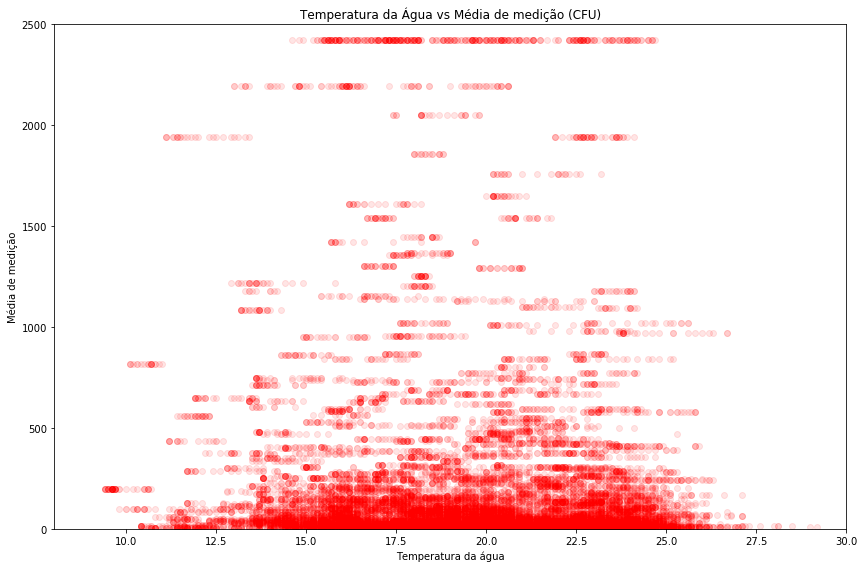

In [19]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(Temperatura.WtrTemperature, Temperatura.ReadingMean, c='red', alpha=0.1)
plt.title('Temperatura da Água vs Média de medição (CFU)')
plt.ylabel('Média de medição')
plt.xlabel('Temperatura da água')


plt.tight_layout()
plt.axis([8,30,0,2500,])
plt.show()

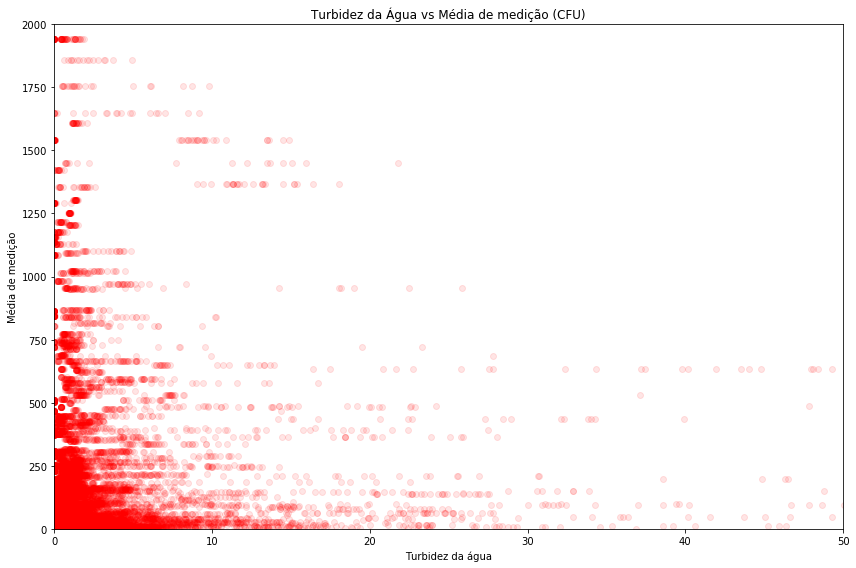

In [25]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(Turbidez.Turbidity, Turbidez.ReadingMean,  c='red', alpha=0.1)
plt.title('Turbidez da Água vs Média de medição (CFU)')
plt.ylabel('Média de medição')
plt.xlabel('Turbidez da água')



plt.tight_layout()
plt.axis([0,50,0,2000])
plt.show()



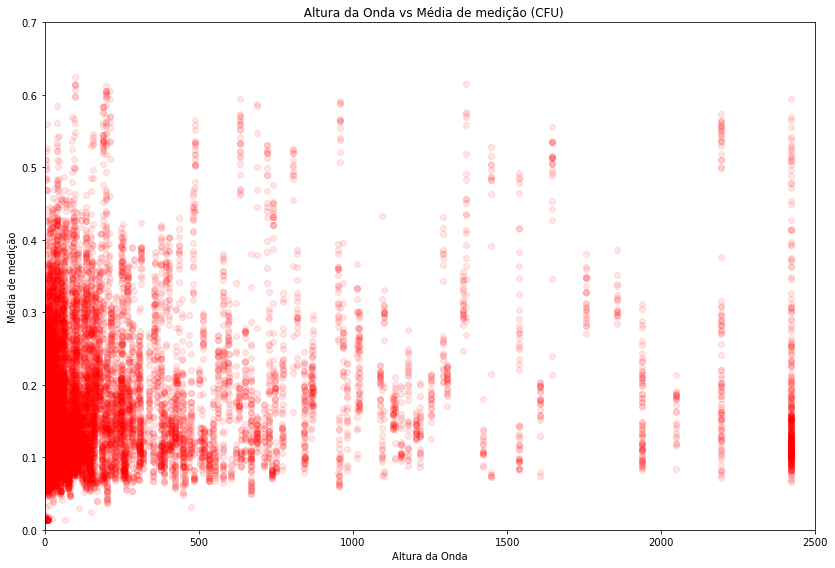

In [27]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(Altura_Onda.ReadingMean, Altura_Onda.WaveHeight, c='red', alpha=0.1)
plt.title('  Altura da Onda vs Média de medição (CFU)')
plt.ylabel('Média de medição')
plt.xlabel('Altura da Onda')


plt.tight_layout()
plt.axis([0,2500,0,0.7,])
plt.show()

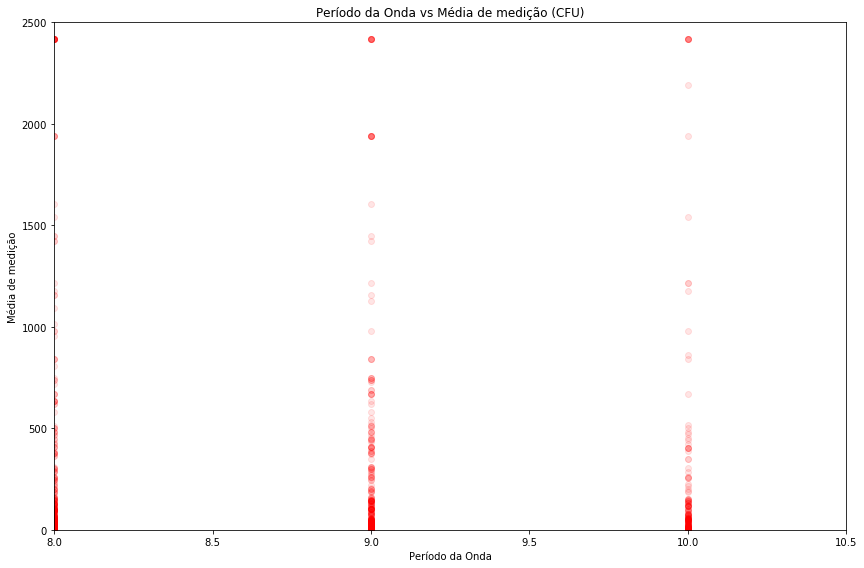

In [23]:
fig = plt.figure(figsize=(12, 8))
plt.scatter(Periodo_Onda.WavePeriod, Periodo_Onda.ReadingMean,  c='red', alpha=0.1)
plt.title('Período da Onda vs Média de medição (CFU)')
plt.ylabel('Média de medição')
plt.xlabel('Período da Onda')


plt.tight_layout()
plt.axis([8,10.5,0,2500])
plt.show()